In [1]:
using HDF5, StatsBase

In [2]:
arxname="/home/karel/BRWFiles/Facilitada/Completo_19115s1cut_single_event_preproc.h5"

"/home/karel/BRWFiles/Facilitada/Completo_19115s1cut_single_event_preproc.h5"

In [3]:
arx=h5open(arxname)

HDF5 data file: /home/karel/BRWFiles/Facilitada/Completo_19115s1cut_single_event_preproc.h5

In [4]:
names(arx)

7-element Array{String,1}:
 "CSDALindenberg"
 "CanalesBuenos" 
 "CanalesMalos"  
 "LFPSaturados"  
 "desde"         
 "freq"          
 "hasta"         

In [5]:
canales=read(arx["CanalesBuenos"])
lfp=read(arx["LFPSaturados"]);
nmax=size(lfp)[3]

2000

In [6]:
using PyPlot

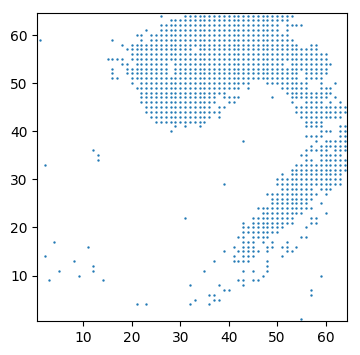

PyObject <matplotlib.collections.PathCollection object at 0x7f3a280eb438>

In [7]:
ff=figure(figsize=(4,4))
xlim(0.5,64.5)
ylim(0.5,64.5)
scatter(canales[:,2], canales[:,1], s=0.5)

In [11]:
function euclidist(xxs::Array, yys::Array)
    result=sqrt(sum((xxs.-yys).^2))
end

euclidist (generic function with 1 method)

In [21]:
function puntoZ2enlinea(puntoini::Array, direccion)
    # los puntos estan en "renglon columna"
    # origen abajo izquierda llamado [1,1]
    xo=puntoini[2]
    yo=puntoini[1]
    result=[yo,xo]
    
    if isapprox(direccion, pi, rtol=0.01)
        x1=1
        y1=yo
        result=[y1,x1]
    elseif isapprox(direccion, pi/2, rtol=0.01)
        x1=xo
        y1=64
        result=[y1,x1]
    elseif isapprox(direccion, 0, rtol=0.01)
        x1=64
        y1=yo
        result=[y1,x1]
    elseif  isapprox(direccion, 3*pi/2, rtol=0.01) 
       x1=xo
       y1=1
        result=[y1,x1]
    else
        #cruce pared izquierda:
        xizq=1
        yizq=(xo-xizq)*tan(direccion)+yo
        #cruce pared derecha
        xder=64
        yder=(xo-xder)*tan(direccion)+yo
        #cruce arriba
        yup=64
        xup=xo+(yup-yo)/tan(direccion)
        #cruce abajo
        ydow=1
        xdow=xo+(ydow-yo)/tan(direccion)
        
        cruces=[[xizq, yizq], [xder, yder], [xup, yup], [xdow, ydow]]
        
        distan=map(xxs->euclidist(xxs, [xo,yo]), cruces)
        (dd, idx)=findmin(distan)
        
        result=cruces[idx]
    end
    
    return result    
        
end

    #=
function orderelectrodes(xxs::Set, puntoinicial::Array;
                         dextro=true, inidir=3.1415)
    

end
    =#

puntoZ2enlinea (generic function with 1 method)

In [22]:
xx0=[31,32]
dire=2.0
bla=puntoZ2enlinea(xx0, dire)

2-element Array{Float64,1}:
 45.72972663080857
  1.0             

In [16]:
nchan=size(canales)[1]

1050

In [72]:
function frediaconis(datos)
    n=length(datos)
    m=iqr(datos)
    result=2*m/cbrt(n)
    return result
end
    
function sacaentropia(datos)
    binsize=frediaconis(datos)
    (vmin,vmax)=extrema(datos)
    if(binsize != 0 )
        rango=vmin:binsize:vmax
        histodo=fit(Histogram,datos,rango)
        pdf=histodo.weights./nmax;
        result=(entropy(pdf), binsize)
    else
        result=(0, binsize)
    end
    return result
end

sacaentropia (generic function with 1 method)

In [76]:
hetas=zeros(nchan)
for j=1:nchan
    reng,col=canales[j,1],canales[j,2]
    ejemplo=lfp[reng,col,:]
    hetas[j]=sacaentropia(ejemplo)[2]
end

In [77]:
ejemplo=lfp[48,30,:]
sacaentropia(ejemplo)
iqr(ejemplo)

36.758423f0

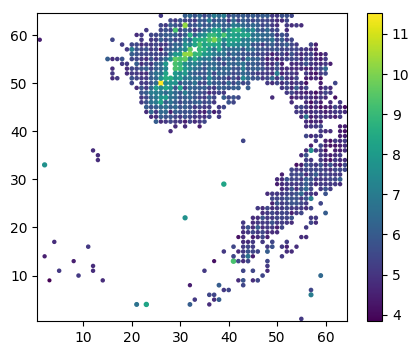

PyObject <matplotlib.colorbar.Colorbar object at 0x7f2991459f28>

In [78]:
ff=figure(figsize=(5,4))
xlim(0.5,64.5)
ylim(0.5,64.5)
scatter(canales[:,2], canales[:,1], s=hetas, c=hetas)
colorbar()

In [82]:
todas=zeros(64,64)
for j=1:64, k=1:64
    ejemplo=lfp[j,k,:]
    if(j,k)!=(1,1)
    todas[j,k]=sacaentropia(ejemplo)[2]
    end
end

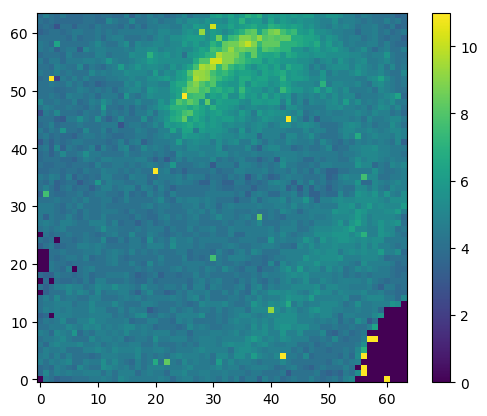

PyObject <matplotlib.colorbar.Colorbar object at 0x7f29911b4b70>

In [86]:
imshow(todas, origin="lower", vmin=0, vmax=11)
colorbar()